In [1]:
%matplotlib inline
import random
import os
import re
import unicodedata
import io
import time

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
SOS_TOKEN = 1
EOS_TOKEN = 2

In [4]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2idx = {'SOS' : SOS_TOKEN, 'EOS' : EOS_TOKEN}
        self.idx2word = {v : k for k,v in self.word2idx.items()}
        self.word2cnt = {}
        self.idx = 3
        
    def add_word(self, w):
        if w not in self.word2idx:
            self.word2idx[w] = self.idx
            self.idx2word[self.idx] = w
            self.word2cnt[w] = 1
            self.idx += 1
        else:
            self.word2cnt[w] += 1
    
    def add_sentence(self, s):
#         s = s.lower().strip()    # just to be sure
        for w in s.split(' '):
            self.add_word(w)

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):                                      #? why convert 2 ascii
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [6]:
t = 'addas.'

In [7]:
x = re.sub(r"[^A-Za-z0-9,.!\/'+=]", " ", t)
x = re.sub(r"\.", r" . ", t)
x

'addas . '

In [8]:
# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
#     s = s.lower().strip()
    s = re.sub(r"[^A-Za-z0-9,.!\/'+=]", " ", s)
    s = re.sub(r"!", " ! ", s)
    s = re.sub(r"\.", " . ", s)
    s = re.sub(r"what's", "what is ", s)
    s = re.sub(r"it's", r"it is", s)
    s = re.sub(r"\'s", " ", s)
    s = re.sub(r" n ", " and ", s)
    s = re.sub(r"\'ve", " have ", s)
    s = re.sub(r"can't", "cannot ", s)
    s = re.sub(r"n't", " not ", s)
    s = re.sub(r"i'm", "i am ", s)
    s = re.sub(r"\'re", " are ", s)
    s = re.sub(r"\'d", " would ", s)
    s = re.sub(r"\'ll", " will ", s)
    s = re.sub(r",", " ", s)
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"\^", " ^ ", s)
    s = re.sub(r"\+", " + ", s)
    s = re.sub(r"\-", " - ", s)
    s = re.sub(r"\=", " = ", s)
    s = re.sub(r"'", " ", s)
    s = re.sub(r":", " : ", s)
    s = re.sub(' +', ' ', s)
    
    s = s.strip()
    
    return s

In [9]:
def indent_end(s):
    if s[-1] in ['|', '?', '!', '।']:
        s = s[:-1] + ' ' + s[-1]
    return s

In [10]:
def read_langs(lang1, lang2, reverse = False):
    data = io.open(f'{lang1}-{lang2}/{lang1}.txt').read().strip().split('\n')
    pairs = [[normalize_string(s) for s in line.split('\t')] for line in data]
    pairs = []
    for line in data:
        s = line.split('\t')
        pairs.append([normalize_string(s[0]), indent_end(s[1])])
    
    if reverse:
        pairs = [list(reversed(pair)) for pair in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

In [11]:
def prepare_data(lang1, lang2, reverse = False):
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    
    print("Read %s sentence pairs" % len(pairs))
    print(random.choice(pairs))
    print(random.choice(pairs))
    
    print("Counting words...")
    print(input_lang.name, input_lang.idx)
    print(output_lang.name, output_lang.idx)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('hin', 'eng', False)
print(random.choice(pairs))

Read 2867 sentence pairs
['have a nice time .', 'मज़े करो ।']
['i forgot to ask him .', 'मैं उससे पूछना भूल गया ।']
Counting words...
hin 2359
eng 2970
['let him in .', 'उसे अंगर आने दो ।']


In [12]:
MAX_LENGTH = max(len(pair[0]) for pair in pairs)
MAX_LENGTH

127

## Embedding

In [13]:
sorted(output_lang.word2idx.items(), key = lambda x : x[1])[-10:]

[('ट्रेफ़िक', 2960),
 ('हादसे', 2961),
 ('कीड़ों', 2962),
 ('परेशानी', 2963),
 ('जिस', 2964),
 ('करें।', 2965),
 ('दूसरी', 2966),
 ('अनुवादों', 2967),
 ('प्रभावित', 2968),
 ('दें', 2969)]

In [14]:
eng_vocab_size = input_lang.idx + 1

In [15]:
hin_vocab_size = output_lang.idx + 1

In [16]:
eng_vocab_size, hin_vocab_size

(2360, 2971)

########################################################################################################

In [ ]:
embedding_matrix = np.zeros((eng_vocab_size, 300))

In [ ]:
for data in io.open('../../Numberbatch Embeddings/numberbatch-en.txt').read().split('\n'):
    if word in input_lang.word2idx:
        word, vec = data.split('\t')
        embedding_matrix[input_lang.word2idx[word]] = vec

In [ ]:
word_present = []
for word in input_lang.word2idx:
    if word

## Encoder

![](encoder.png)

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(self, x, hidden):
        embedded = self.embedding(x).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

![](AttnDecoderRNN.png)

In [18]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p, max_length = MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(p = dropout_p)
        self.attn = nn.Linear(2 * hidden_size, max_length)
        self.attn_combine = nn.Linear(2 * hidden_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden, encoder_outputs):
        embedded = self.embedding(x).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), dim = 1)), dim = 1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        attn_combine = self.attn_combine(torch.cat((embedded[0], attn_applied[0]), dim = 1)).unsqueeze(0)
        output = F.relu(attn_combine)
        
        output, hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.output(output[0]), dim = 1)
        
        return output, hidden, attn_weights
        
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

### Preparing training data

In [19]:
def indexes_from_sentence(lang, sentence):
    return [lang.word2idx[word] for word in sentence.split(' ')]

def tensor_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_TOKEN)
    return torch.tensor(indexes, dtype = torch.long).view(-1, 1)

def tensors_from_pair(pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    
    return input_tensor, target_tensor

In [20]:
tensors_from_pair(pairs[0])

(tensor([[3],
         [4],
         [2]]), tensor([[3],
         [4],
         [2]]))

**Teacher forcing** is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

In [21]:
teacher_forcing_ratio = 0.6

In [22]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length = MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)
    encoder_hiddens = torch.zeros(max_length, encoder.hidden_size)
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]
        encoder_hiddens[ei] = encoder_hidden[0][0]
    
    loss = 0
    
    decoder_hidden = encoder_hidden
    
    decoder_input = torch.tensor([[SOS_TOKEN]], dtype = torch.long)
    
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(decoder_input, decoder_hidden, encoder_outputs)
        
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        
        if use_teacher_forcing:
            decoder_input = target_tensor[di]
            loss += criterion(decoder_output, target_tensor[di])
        else:
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()             # detach from history as input
            
            loss += criterion(decoder_output, target_tensor[di])
        
        if decoder_input.item() == EOS_TOKEN:
            break
    
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

#### This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [23]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

#### The whole training process looks like this:
* Start a timer
* Initialize optimizers and criterion
* Create set of training pairs
* Start empty losses array for plotting

In [24]:
def train_iters(encoder, decoder, n_iters, print_every = 1000, plot_every = 100, learning_rate = 0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset after every print_every
    plot_loss_total = 0  # Reset after every plot_every
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr = learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr = learning_rate)
    
    training_pairs = [tensors_from_pair(random.choice(pairs)) for _ in range(n_iters)]
    
    criterion = nn.NLLLoss()
    
    for n_iter in range(1, n_iters + 1):
        training_pair = training_pairs[n_iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        plot_losses.append(loss)
        
        print_loss_total += loss
        plot_loss_total += loss

        if n_iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, n_iter / n_iters),
                                         n_iter, n_iter / n_iters * 100, print_loss_avg))

        if n_iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [26]:
def evaluate(encoder, decoder, sentence, max_length = MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_TOKEN]])  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_TOKEN:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.idx2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [27]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 31s (- 150m 26s) (1000 1%) 4.9046
3m 5s (- 151m 18s) (2000 2%) 4.3518
4m 41s (- 151m 38s) (3000 3%) 3.9469
6m 25s (- 154m 22s) (4000 4%) 3.4471
8m 14s (- 156m 37s) (5000 5%) 3.1132
10m 6s (- 158m 26s) (6000 6%) 2.8288
12m 0s (- 159m 36s) (7000 7%) 2.6157
13m 56s (- 160m 18s) (8000 8%) 2.2781
15m 50s (- 160m 12s) (9000 9%) 2.0561
17m 47s (- 160m 6s) (10000 10%) 1.9599
19m 47s (- 160m 8s) (11000 11%) 1.8114
21m 35s (- 158m 23s) (12000 12%) 1.6606
23m 25s (- 156m 47s) (13000 13%) 1.5933
25m 13s (- 154m 57s) (14000 14%) 1.4429
27m 1s (- 153m 6s) (15000 15%) 1.3917
28m 51s (- 151m 32s) (16000 16%) 1.2823
30m 41s (- 149m 49s) (17000 17%) 1.2684
32m 29s (- 147m 59s) (18000 18%) 1.1932
34m 17s (- 146m 10s) (19000 19%) 1.1581
36m 8s (- 144m 34s) (20000 20%) 1.1214
38m 5s (- 143m 16s) (21000 21%) 1.0411
39m 55s (- 141m 34s) (22000 22%) 0.9766
41m 45s (- 139m 46s) (23000 23%) 0.9561
43m 36s (- 138m 6s) (24000 24%) 0.9543
45m 42s (- 137m 7s) (25000 25%) 0.9163
47m 40s (- 135m 41s) (26000 26%) 0

<Figure size 432x288 with 0 Axes>

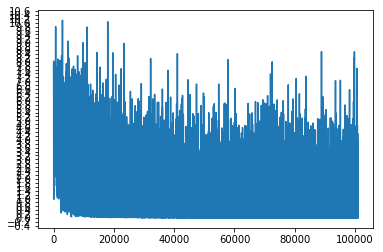

In [28]:
hidden_size = 256
encoder1 = EncoderRNN(eng_vocab_size, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, hin_vocab_size, dropout_p = 0.1)

train_iters(encoder1, attn_decoder1, 100000, print_every = 1000)

In [68]:
evaluate_randomly(encoder1, attn_decoder1)

> you are at it again .
= तुम फिरसे चालू हो गए ।
< तुम इसे फिरसे फिरसे फिरसे हो गए हो । <EOS>

> you must get rid of such a habit .
= तुम्हे इस तरह की आदत तोड़ देनी चाहिए ।
< तुम्हे इस तरह की आदत तोड़ देनी चाहिए । <EOS>

> we have two unused rooms in our house .
= हमारे पास घर में दो कमरे हैं जिनका हम इस्तेमाल नहीं कर रहे हैं ।
< हमारे पास घर में के पास घर हैं । <EOS>

> i do not know .
= मुझे नहीं पता ।
< मुझे नहीं मालूम । <EOS>

> i forgot .
= मैं भूल गई ।
< मैं भूल गया । <EOS>

> she complained to me of his rudeness .
= उसने मुझसे उसकी असभ्यता के बारे में शिक़ायत करी ।
< उसने मुझसे उसकी उसकी उसकी शिक़ायत दिया । <EOS>

> my money was stolen .
= मेरे पैसे चोरी हो गए ।
< मेरे चोरी हो गया था । <EOS>

> we would die without air .
= हम हवा के बिना मर जाएँगे ।
< हमने हवा के बिना मर । <EOS>

> is it possible to borrow money
= क्या पैसे उधार लिए जा सकते हैं ?
< वहाँ क्यों है, क्या ? <EOS>

> both of my sisters are married .
= मेरी दोनो बहनें शादीशुदा हैं ।
< मेरी दोनो दोनो दोनो हैं हैं हैं ह

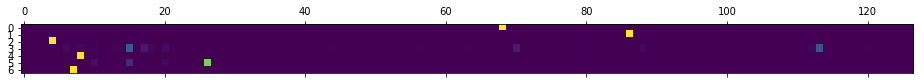

In [81]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "i want a drink .")
plt.matshow(attentions.numpy())

input = wow !
output = बधाई ! <EOS>


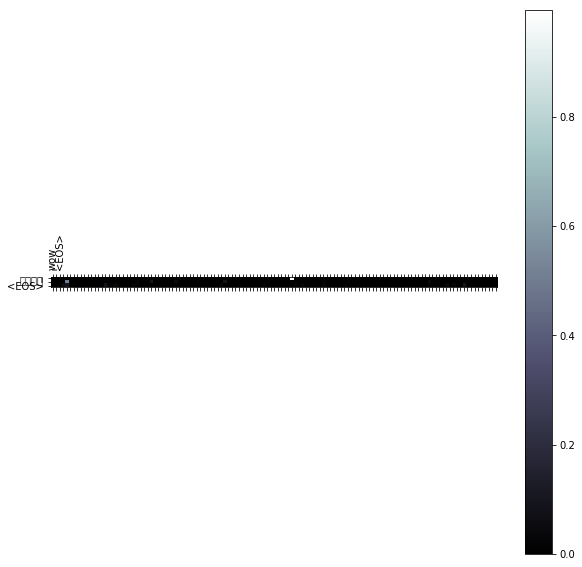

In [85]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("wow !")

# evaluateAndShowAttention("elle est trop petit .")

# evaluateAndShowAttention("je ne crains pas de mourir .")

# evaluateAndShowAttention("c est un jeune directeur plein de talent .")

In [89]:
from IPython.display import clear_output

In [96]:
s = input('Enter sentence :: ')
output_words, attentions = evaluate(encoder1, attn_decoder1, normalize_string(s))
print(' '.join(output_words))

क्या स्कूल से हुआ था ? <EOS>
